In [1]:
import tensorflow as tf
import numpy as np
seed = 123
np.random.seed(seed)
import cifar10_utils
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers, optimizers
from keras.applications import VGG16
import itertools

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/s

In [2]:
import tensorflow as tf
import os
from keras.backend.tensorflow_backend import set_session
os.environ["CUDA_VISIBLE_DEVICES"]="0"
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )

num_classes = 10
image_shape = x_train.shape[1:]

#training
batch_size = 100
base_epochs = 1

baseMapNum = 32
weight_decay = 1e-4
class_names = ['other', 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


model = cifar10_utils.create_base_model(image_shape, baseMapNum, weight_decay, 'kaggle')
model.add(Dense(4, activation='softmax'))
model.summary()
initial_weights = model.get_weights()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_

selected classes: ['cat', 'dog', 'deer']
[20348 26167 29567 39171 34704 18934 15470 46452  1826 43529]
current other class: [ 1  2  3  7  8  9 10]
current target class: [4 6 5]
all target target class: [4 6 5]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 5000
(15000,) (5000,)
first running:

======Training From Scratch=========

Instructions for updating:
Use tf.cast instead.
y_sum 1399
y_sum 1903
y_sum 2746
[0.6580000042915344, 0.7949999988079071, 0.847000002861023]


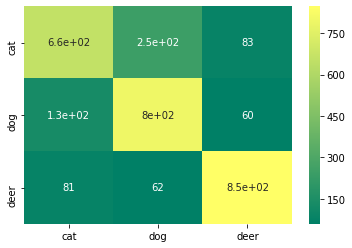

second running:

======Training From Scratch=========



KeyboardInterrupt: 

In [4]:
num_classes_excluding_other = 3
full_class_ids = np.arange(1, 11)  # 1-10
np.random.shuffle(full_class_ids)

full_target_class_ids = full_class_ids[:num_classes_excluding_other]

print('selected classes: ' + str([class_names[el] for el in full_target_class_ids]))

full_target_class_ids_all_permutation = list(itertools.permutations(full_target_class_ids))

cur_target_class_ids = np.copy(full_target_class_ids)
(cur_train_data, cur_train_labels) = cifar10_utils.generate_data(cur_target_class_ids, full_target_class_ids, 
                                                               x_train, y_train, False, seed)

#TODO: temp testing code
all_data = list(zip(cur_train_data, cur_train_labels))
np.random.shuffle(all_data)
cur_train_data = np.array([i[0] for i in all_data])
cur_train_labels = np.array([i[1] for i in all_data])

print('first running:')
cifar10_utils.one_run(model, cur_train_data, cur_train_labels, x_test, y_test, batch_size, 
                      full_target_class_ids_all_permutation[0], initial_weights, 
                      base_epochs, datagen, class_names)


print('second running:')
cifar10_utils.one_run(model, cur_train_data, cur_train_labels, x_test, y_test, 
                      batch_size, full_target_class_ids_all_permutation[0], initial_weights, 
                      base_epochs, datagen, class_names)


print('third running:')
cifar10_utils.one_run(model, cur_train_data, cur_train_labels, x_test, y_test, 
                      batch_size, full_target_class_ids_all_permutation[0], initial_weights, 
                      base_epochs, datagen, class_names)

print('4th running:')
cifar10_utils.one_run(model, cur_train_data, cur_train_labels, x_test, y_test, 
                      batch_size, full_target_class_ids_all_permutation[0], initial_weights, 
                      base_epochs, datagen, class_names)

print('5th running:')
cifar10_utils.one_run(model, cur_train_data, cur_train_labels, x_test, y_test, 
                      batch_size, full_target_class_ids_all_permutation[0], initial_weights, 
                      base_epochs, datagen, class_names)

# for full_target_class_ids_eli in full_target_class_ids_all_permutation: 
#     print('sequence of class addition: ' + str([class_names[el] for el in full_target_class_ids_eli]))
#     cifar10_utils.one_run(model, cur_train_data, cur_train_labels, x_test, y_test, batch_size, full_target_class_ids_all_permutation[0], initial_weights, base_epochs, datagen, class_names)
#         cifar10_utils.one_run(model, x_train, y_train, x_test, y_test, batch_size, full_target_class_ids_all_permutation[0], initial_weights, base_epochs, datagen, class_names)